<a href="https://colab.research.google.com/github/haji8-de/AIFFEL_quest_rs/blob/main/Playground/pg01/playground_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 기본 초기화 소스

In [ ]:
!pip install torchinfo

In [ ]:
# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from torchinfo import summary
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))


In [ ]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import models
from torchvision import transforms
from torchvision.datasets import ImageFolder


hyperparams = {
    "batch_size": 4,
    "learning_rate": 0.0001,
    "epochs": 5,
    "transform": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.48235, 0.45882, 0.40784],
                std=[0.229, 0.224, 0.225],
            ),
        ]
    ),
}

## 데이터 로드 소스 from torchVision

In [ ]:
trainset = torchvision.datasets.Imagenette(root='./data', split='train', download=True, transform=hyperparams['transform'])
testset = torchvision.datasets.Imagenette(root='./data', split='val', download=True, transform=hyperparams['transform'])

trainloader_2 = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader_2 = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

# trainloader_2 = torch.utils.data.DataLoader(ds_split['train'], batch_size=32, shuffle=True)
# testloader_2 = torch.utils.data.DataLoader(ds_split['test'], batch_size=32, shuffle=False)
# validationloader_2 = torch.utils.data.DataLoader(ds_split['validation'], batch_size=32, shuffle=False)

100%|██████████| 1.56G/1.56G [01:43<00:00, 15.1MB/s]


## 이진 분류된 이미지의 결과를 확인

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def show_multiple_images(data_loader, n_images=9):
    # 1. 데이터 로더에서 배치 가져오기
    # iter(dataset)이 아니라 iter(data_loader)를 사용해야 배치가 나옵니다.
    dataiter = iter(data_loader)
    images, labels = next(dataiter)

    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten()

    # 요청하신 labels_list (ImageNet 스타일 클래스명)
    labels_list = [
        ('tench', 'Tinca tinca'),
        ('English springer', 'English springer spaniel'),
        ('cassette player',),
        ('chain saw', 'chainsaw'),
        ('church', 'church building'),
        ('French horn', 'horn'),
        ('garbage truck', 'dustcart'),
        ('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser'),
        ('golf ball',),
        ('parachute', 'chute')
    ]

    for i in range(n_images):
        ax = axes[i]

        # 2. 이미지 역정규화 (Un-normalization)
        # Tensor(C,H,W) -> Numpy(H,W,C)
        img = images[i].cpu().numpy().transpose((1, 2, 0))

        # 일반적인 ImageNet/ResNet 정규화 값 (Mean/Std) 복원
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1) # 0~1 사이로 자름

        ax.imshow(img)

        # 3. 라벨 인덱스 추출 (IndexError 방지 로직 포함)
        # labels가 [binary, breed] 리스트인지, 그냥 텐서인지 확인
        if isinstance(labels, list):
            label_idx = labels[0][i].item()
        else:
            label_idx = labels[i].item()

        # 4. 텍스트 매핑 (튜플 처리)
        if 0 <= label_idx < len(labels_list):
            # 튜플의 첫 번째 요소만 가져옴 (예: 'tench')
            label_text = labels_list[label_idx][0]
        else:
            # 리스트 범위를 벗어나는 인덱스가 나오면 숫자만 출력
            label_text = f"Unknown ({label_idx})"

        ax.set_title(f"{label_text}", fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

Trainloader_2 (Binary Labels):


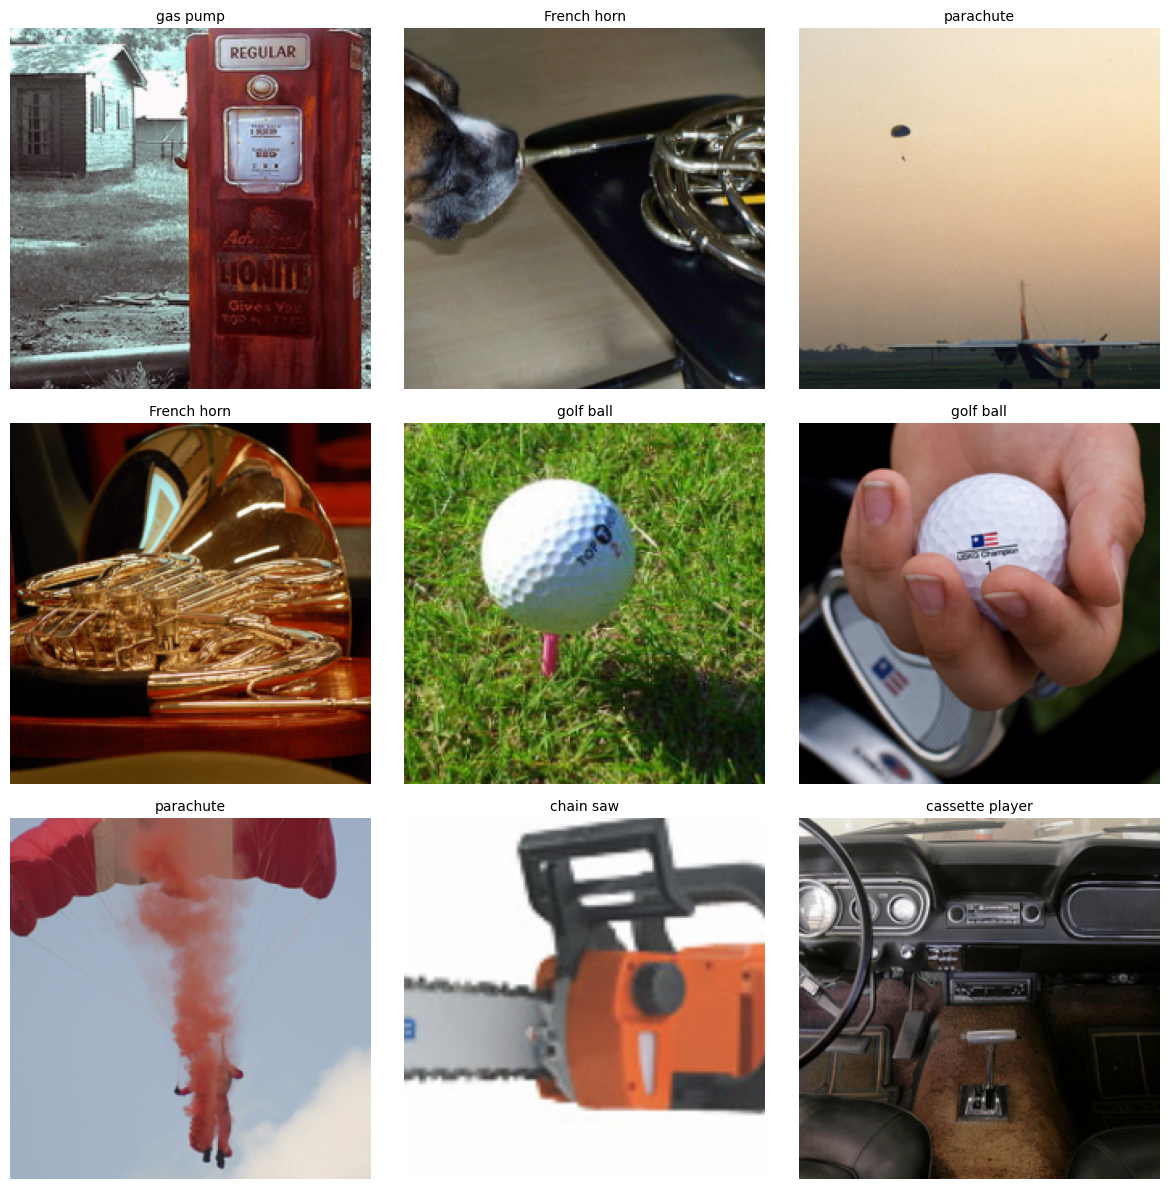


Testloader_2 (Binary Labels):


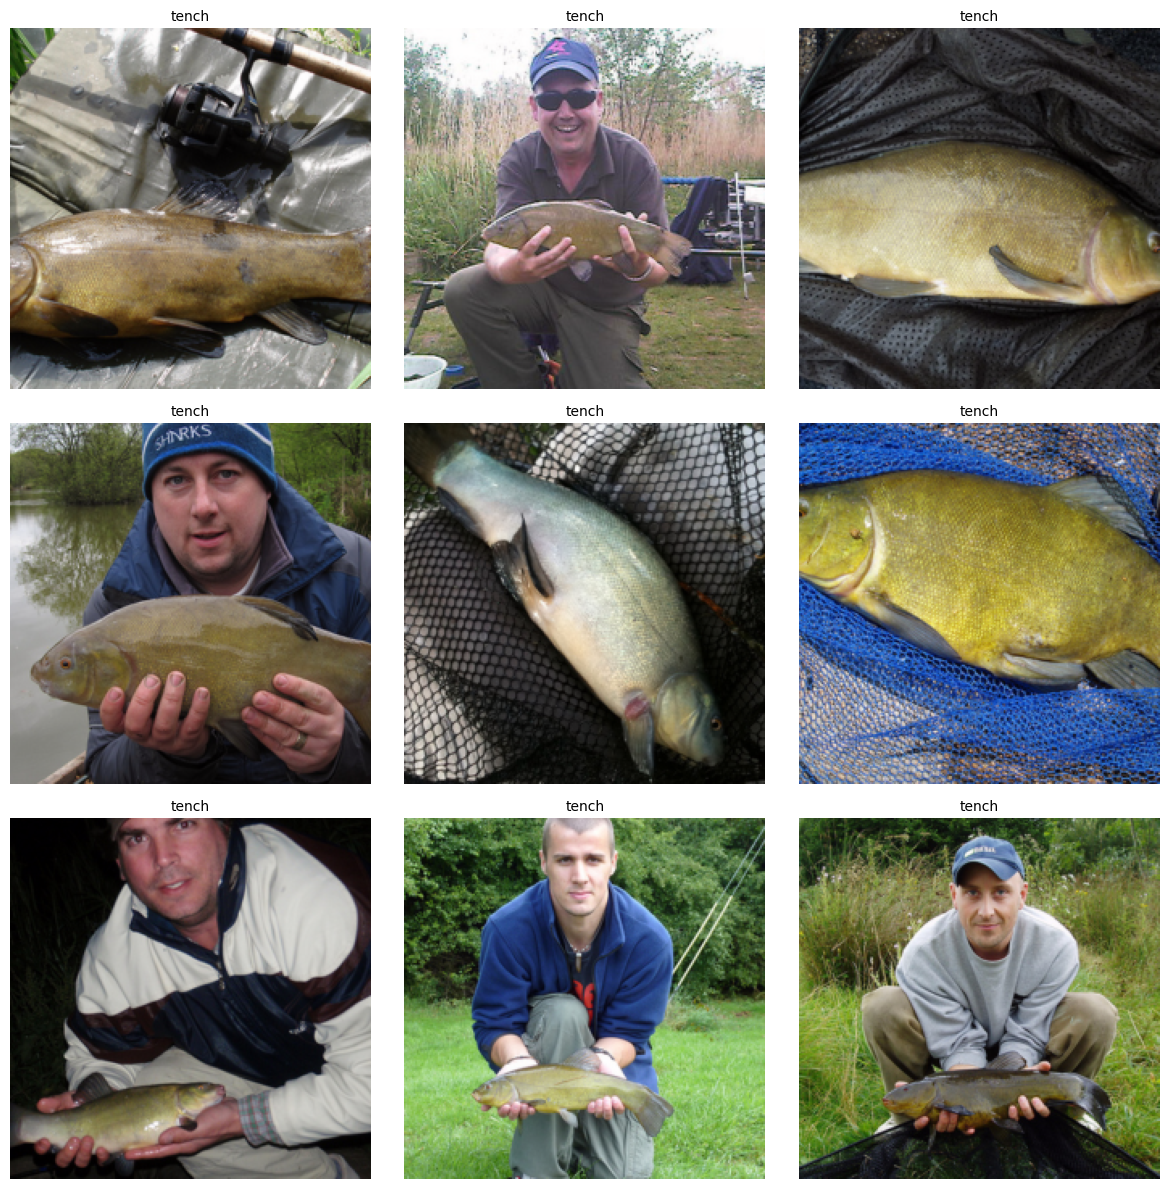

In [ ]:
# trainloader_2 에 대한 이진 레이블 시각화

# --- 실행 ---
# 주의: 함수 인자에는 Dataset이 아니라 DataLoader를 넣어야 합니다.
print("Trainloader_2 (Labels):")
show_multiple_images(trainloader_2)


# testloader_2 에 대한 이진 레이블 시각화
print("\nTestloader_2 (Labels):")
show_multiple_images(testloader_2)

# ResNet 구현체

## BasicBlock

In [ ]:
from torch import nn


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            inplanes, planes,
            kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            planes, planes,
            kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or inplanes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    inplanes, self.expansion*planes,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

## resnet 구현체

In [ ]:
import torch


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super().__init__()

        self.inplanes = 64
        self.stem = nn.Sequential(
            nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.inplanes),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.stage1 = self._make_layer(block, 64, layers[0], stride=1)
        self.stage2 = self._make_layer(block, 128, layers[1], stride=2)
        self.stage3 = self._make_layer(block, 256, layers[2], stride=2)
        self.stage4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        layers = []
        layers.append(block(self.inplanes, planes, stride))
        self.inplanes = planes * block.expansion
        for _ in range(num_blocks - 1):
            layers.append(block(self.inplanes, planes, 1))

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.stem(x)
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

## 다양한 resnet 생성

In [ ]:
from torchvision import models
from torchinfo import summary

resnet34 = ResNet(BasicBlock, [3, 4, 6, 3], 10)
torch_model = models.resnet34(weights="ResNet34_Weights.IMAGENET1K_V1")

resnet34_info = summary(resnet34, (1, 3, 224, 224), verbose=0)
torch_model_info = summary(torch_model, (1, 3, 224, 224), verbose=0)

print(resnet34_info.total_params)
print(torch_model_info.total_params)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 181MB/s]


21289802
21797672


## display_predictions


예측된 라벨의 정확도 확인을 위해
예측라벨과 정답 라벨을 이미지와 함께 노출

* class_names = ['cat', 'dog']

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 전역 변수로 정의
labels_list = [
        ('tench', 'Tinca tinca'),
        ('English springer', 'English springer spaniel'),
        ('cassette player',),
        ('chain saw', 'chainsaw'),
        ('church', 'church building'),
        ('French horn', 'horn'),
        ('garbage truck', 'dustcart'),
        ('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser'),
        ('golf ball',),
        ('parachute', 'chute')
    ]

def show_multiple_images(loader, n_images=9):
    """
    데이터셋의 정답 라벨(Ground Truth)만 확인하는 함수
    """
    # 1. 데이터 로더에서 배치 가져오기
    dataiter = iter(loader)
    images, labels = next(dataiter)

    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.flatten()

    for i in range(n_images):
        if i >= len(images): break # 배치 크기가 n_images보다 작을 경우 방지

        ax = axes[i]

        # 2. 이미지 역정규화 (Tensor -> Numpy & Un-normalize)
        img = images[i].cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        ax.imshow(img)

        # 3. 라벨 추출 (IndexError 방지: 리스트인지 텐서인지 확인)
        if isinstance(labels, list):
            binary_label_idx = labels[0][i].item() # [binary, breed] 형태일 때
        else:
            binary_label_idx = labels[i].item()    # 그냥 텐서일 때

        # 4. 텍스트 매핑
        if 0 <= binary_label_idx < len(binary_labels_map):
            label_text = binary_labels_map[binary_label_idx]
        else:
            label_text = f"Unknown ({binary_label_idx})"

        ax.set_title(f"True: {label_text}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()


def display_predictions(loader, model, class_names, device, n_images=9):
    """
    모델의 예측값(Prediction)과 정답(True)을 비교하는 함수
    """
    # 1. 데이터 가져오기
    dataiter = iter(loader)
    images, labels = next(dataiter)

    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.flatten()

    # 모델 평가 모드 전환 (중요)
    model.eval()

    with torch.no_grad():
        for i in range(n_images):
            if i >= len(images): break

            ax = axes[i]

            # 2. 이미지 역정규화 및 출력
            img = images[i].cpu().numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = std * img + mean
            img = np.clip(img, 0, 1)

            ax.imshow(img)

            # 3. 모델 예측
            # 배치 차원 추가 [3, 224, 224] -> [1, 3, 224, 224] 후 디바이스로 이동
            input_tensor = images[i].unsqueeze(0).to(device)
            outputs = model(input_tensor)

            # 예측 클래스 인덱스 가져오기
            _, predicted = torch.max(outputs.data, 1)
            predicted_idx = predicted.item()

            # 예측된 클래스 이름 (class_names 리스트 사용)
            if 0 <= predicted_idx < len(class_names):
                predicted_class_name = class_names[predicted_idx]
            else:
                predicted_class_name = f"Idx {predicted_idx}"

            # 4. 실제 정답 라벨 추출 (IndexError 방지 로직)
            if isinstance(labels, list):
                true_idx = labels[0][i].item()
            else:
                true_idx = labels[i].item()

            # 정답 클래스 이름 (binary_labels_map 사용)
            if 0 <= true_idx < len(labels_list):
                true_label_text = labels_list[true_idx]
            else:
                true_label_text = f"Unknown ({true_idx})"

            # 5. 제목 설정 (True vs Pred)
            # 정답과 예측이 다르면 빨간색으로 표시하는 로직 추가 (선택사항)
            title_color = 'black' if true_idx == predicted_idx else 'red'

            ax.set_title(f"True: {true_label_text}\nPred: {predicted_class_name}", color=title_color)
            ax.axis('off')

    plt.tight_layout()
    plt.show()
    # 모델을 다시 train 모드로 돌려놓으려면 주석 해제
    # model.train()

# ResNet-34, ResNet-50 각각 plain모델과 residual모델

## PlainBlock 선언

In [ ]:
import torch
import torch.nn as nn

class PlainBlock(nn.Module):
    """
    ResNet의 BasicBlock과 구조는 같지만,
    Skip Connection(+ identity)이 없는 블록
    """
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(PlainBlock, self).__init__()

        # 첫 번째 Conv (Stride가 1이 아닐 수도 있음)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        # 두 번째 Conv
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        # 1. Convolution 통과
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # [차이점] 여기서 ResNet은 'out += x'를 하지만, Plain 모델은 하지 않습니다.

        out = self.relu(out)
        return out


## Bulid Plainnet 선언

In [ ]:
def build_plainnet(is_50=False, input_shape=(32, 32, 3), num_classes=10):
    """
    ResNet-34와 동일한 층 수를 가지지만,
    Skip Connection이 없는 PlainNet-34 모델을 생성합니다.
    """

    # ResNet-34와 동일한 레이어 구성
    layers = [3, 4, 6, 3]

    # 블록 타입으로 BasicBlock 대신 PlainBlock을 사용
    # is_50(Bottleneck) 옵션은 PlainNet 실험에서 보통 34층 이하를 비교하므로 무시하거나 False로 둠
    model = ResNet(PlainBlock, layers, num_classes=num_classes)

    return model

## plainnet_34_2 수행

In [ ]:
plainnet_34_2 = build_plainnet(is_50=False, input_shape=(32, 32,3), num_classes=10)
# print(summary(plainnet_34_2))

# print(plainnet_34_2.total_params)

# 학습부

In [ ]:
BATCH_SIZE = 256
EPOCH = 10

In [ ]:
import time
import torch
import torch.nn as nn
import torch.optim as optim

def model_run_epoch_classnet(origin_model):
    # 1. Setup
    current_time = time.time()
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Move model to device FIRST
    model = origin_model.to(device)

    criterion = nn.CrossEntropyLoss().to(device)

    # CRITICAL FIX 1: Optimizer must be defined AFTER moving model to device.
    # We must optimize 'model.parameters()', NOT 'origin_model.parameters()'.
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

    origin_model_train_losses = []
    origin_model_val_accuracy = []

    print(f"Training on device: {device}")

    # Ensure EPOCH is defined (or pass it as an argument). Assuming global variable for now.
    for epoch in range(EPOCH):
        # CRITICAL FIX 2: Use local 'model' variable, not global 'resnet34'
        model.train()

        running_loss = 0.0
        epoch_loss = 0.0
        correct = 0
        total = 0

        # --- TRAINING LOOP ---
        for i, (inputs, labels) in enumerate(trainloader_2, 0):
            inputs = inputs.to(device)

            # --- [FIX FOR VALUE ERROR: TARGET UNPACKING] ---
            # Handles both list (multi-label) and tensor (single-label) cases
            if isinstance(labels, list):
                targets = labels[0].to(device).long()
            else:
                targets = labels.to(device).long()
            # -----------------------------------------------

            optimizer.zero_grad()
            outputs = model(inputs)

            # Safety Check: Prevent crash if shapes mismatch
            if targets.shape[0] != outputs.shape[0]:
                 print(f"Error: Shape Mismatch! Output: {outputs.shape}, Target: {targets.shape}")
                 continue # Skip this batch

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            # Stats
            loss_val = loss.item()
            running_loss += loss_val
            epoch_loss += loss_val

            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

            if i % 100 == 99:
                print(f"[{epoch + 1}, {i + 1:5d}] Step Loss: {running_loss / 100:.3f}")
                running_loss = 0.0

        # End of Training Epoch Stats
        avg_train_loss = epoch_loss / len(trainloader_2)
        train_acc = 100 * correct / total
        origin_model_train_losses.append(avg_train_loss)

        print(f"Epoch {epoch + 1} Finished. Avg Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%")

        # --- VALIDATION LOOP ---
        model.eval()
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in testloader_2:
                inputs = inputs.to(device)

                # --- [FIX APPLIED TO VALIDATION TOO] ---
                if isinstance(labels, list):
                    targets = labels[0].to(device).long()
                else:
                    targets = labels.to(device).long()
                # ---------------------------------------

                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)

                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()

        if val_total > 0:
            val_acc = 100 * val_correct / val_total
        else:
            val_acc = 0.0

        origin_model_val_accuracy.append(val_acc)

        print(f"Epoch {epoch + 1}: Validation Accuracy: {val_acc:.2f}%")
        print("-" * 20)

    print("Finished Training")
    print(f"Time elapsed: {time.time() - current_time:.2f} seconds")

    return origin_model_train_losses, origin_model_val_accuracy

In [ ]:
l34,a34 = model_run_epoch_classnet(resnet34)

Training on device: cuda
[1,   100] Step Loss: 2.005
[1,   200] Step Loss: 1.564
Epoch 1 Finished. Avg Loss: 1.6413, Train Acc: 43.25%
Epoch 1: Validation Accuracy: 40.61%
--------------------
[2,   100] Step Loss: 1.220
[2,   200] Step Loss: 1.111
Epoch 2 Finished. Avg Loss: 1.1408, Train Acc: 62.63%
Epoch 2: Validation Accuracy: 56.03%
--------------------
[3,   100] Step Loss: 0.916
[3,   200] Step Loss: 0.875
Epoch 3 Finished. Avg Loss: 0.8999, Train Acc: 70.48%
Epoch 3: Validation Accuracy: 69.89%
--------------------
[4,   100] Step Loss: 0.791
[4,   200] Step Loss: 0.718
Epoch 4 Finished. Avg Loss: 0.7459, Train Acc: 76.06%
Epoch 4: Validation Accuracy: 66.14%
--------------------
[5,   100] Step Loss: 0.623
[5,   200] Step Loss: 0.614
Epoch 5 Finished. Avg Loss: 0.6313, Train Acc: 79.70%


In [ ]:
lp34,ap34 = model_run_epoch_classnet(plainnet_34_2)

In [ ]:
import matplotlib.pyplot as plt

def figure_2chart(title, l1,a1,l2,a2):

    # --- 데이터 준비 (예시 변수명입니다. 실제 저장한 변수명으로 교체하세요) ---
    # 예: epochs = range(1, 11)
    epochs = range(1, len(a1) + 1)

    # 1. 그래프 크기 설정
    plt.figure(figsize=(15, 6))

    # -------------------------------------------------------
    # [왼쪽 그래프] Validation Accuracy 비교
    # -------------------------------------------------------
    plt.subplot(1, 2, 1)
    plt.plot(epochs, a1, 'b-o', label='Res'+title+' (Shortcut O)')
    plt.plot(epochs, a2, 'r--s', label='Plain'+title+' (Shortcut X)')

    plt.title('Validation Accuracy Comparison', fontsize=15)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=12)

    # -------------------------------------------------------
    # [오른쪽 그래프] Validation Loss 비교
    # (Loss 리스트가 있다면 이 부분을 주석 해제하고 사용하세요)
    # -------------------------------------------------------
    plt.subplot(1, 2, 2)

    plt.plot(epochs, l1, 'b-o', label='Res'+title+' Loss')
    plt.plot(epochs, l2, 'r--s', label='Plain'+title+' Loss')
    plt.title('Validation Loss Comparison', fontsize=15)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=12)

    plt.tight_layout()
    plt.show()

In [ ]:
figure_2chart("net34", l34,a34,lp34,ap34)

In [ ]:
class_names = labels_list
display_predictions(trainloader_2, resnet34, class_names, device, n_images=9)